In [13]:
from modules.backtest.strategy import TopKStrategy
from modules.backtest.backtrader import BackTrader
from modules.factor_benchmark.utils import calc_rank_ic, calc_pearson_corr, make_summary
from modules.factor_composition.utils import train_test_split, corr_scorer, unpack_signals
from modules.factor_composition.selector import LassoSelector
from modules.factor_composition.regressor import LassoRegressor
from modules.visualization import generate_visualization
from modules.utils import load_factors

# 加载因子

在使用 factor.py 计算因子之后，我们可以使用 load_factors 加载我们用于研究的数据。

In [14]:
factors, returns, mkt_return = load_factors()

Data variables:
    PAST_RETURN_1           (stk_id, date) float64 nan nan ... 0.001235 0.002483
    PAST_RETURN_2           (stk_id, date) float64 nan nan nan ... 0.0 0.003718
    PAST_RETURN_3           (stk_id, date) float64 nan nan ... 0.001235 0.002483
    PAST_RETURN_5           (stk_id, date) float64 nan nan ... -0.008636
    PAST_RETURN_10          (stk_id, date) float64 nan nan ... -0.0833 -0.07966
    PAST_RETURN_15          (stk_id, date) float64 nan nan ... -0.09914 -0.08081
    PAST_RETURN_VOL_CORR5   (stk_id, date) float64 nan nan ... -0.947 -0.9542
    PAST_RETURN_VOL_CORR10  (stk_id, date) float64 nan nan nan ... 0.2282 0.6005
    PAST_RETURN_VOL_CORR15  (stk_id, date) float64 nan nan nan ... 0.2808 0.2388
    PAST_RETURN_VOL_CORR20  (stk_id, date) float64 nan nan nan ... 0.5257 0.6153


# 划分训练集

我们可以使用 split_train_test 函数将数据划分为训练集和测试集; 你可以通过 test_size 指定测试集大小。

In [15]:
train_dataset, test_dataset = train_test_split(factors, returns, test_size=252)

# 选取因子

我们可以使用 BaseSelector 类来选取因子，它会返回一个因子列表。

这里我们使用 LassoSelector 作为例子，它利用 5-Fold 交叉验证来选取因子。

In [16]:
selector = LassoSelector(corr_scorer, 5)
selected_factors = selector.select(train_dataset)

# 组合因子

我们可以使用 BaseRegressor 类来组合因子，它会返回最终得到的信号。

这里我们使用 LassoRegressor 作为例子，它利用 5-Fold 交叉验证来确定最有超参数。

In [17]:
regressor = LassoRegressor(corr_scorer, 5)
regressor.fit(train_dataset)

# 生成信号

我们可以使用 unpack_signal 类来生成信号，它会返回一个信号列表。

In [18]:
signals = unpack_signals(regressor, train_dataset, test_dataset, returns)

# 信号回测

使用回测模块进行因子回测，回测时我们需要指明回测的策略和手续费，并初始化两个回测模块。
- TopKStrategy：选取因子值最大的前 K 个股票作为买入股票；暂时不考虑做空的情况。
- BackTrader: 回测模块，用于回测因子；接受给定的策略和手续费。

之后用 BackTrader.backtest 接口进行回测，返回回测结果。

In [19]:
strategy = TopKStrategy(k=5)
backtrader_nofee = BackTrader(strategy, 0)
backtrader = BackTrader(strategy, 0.0006)

portfolio_return_nofee = backtrader_nofee.backtest(signals, returns)
portfolio_return = backtrader.backtest(signals, returns)

# 信号评价

首先，计算每天的 rank_ic 和 pearson 相关系数，用于评价因子的预测能力。

然后用 make_summary 接口计算因子的各项指标，包括：年化收益率，年化波动率，年化夏普比率，年化超额收益（测试期），最大回撤（测试期）。

In [20]:
rank_ic = calc_rank_ic(signals, returns)
pearson_corr = calc_pearson_corr(signals, returns)

In [21]:
make_summary(portfolio_return_nofee, portfolio_return, mkt_return, rank_ic, pearson_corr)

,平均 Pearson 相关系数,平均 Spearman 秩相关系数
统计量 (test samples = 252),0.03138,-0.005223


,年化收益率,年化波动率,年化夏普比率,测试期年化超额收益,测试期最大回撤
无手续费 (test samples = 252),0.255400,0.240737,1.060911,0.459242,-0.225200
有手续费 (test samples = 252),0.012769,0.240768,0.053036,0.216612,-0.248743


In [22]:
selector.fitted_result.get_params()["model"].coef_

array([ 1.11896316e-03,  5.58325660e-04,  2.07468820e-04, -8.14446041e-04,
        8.35550815e-05, -5.36017023e-04,  6.24263785e-05, -1.30815549e-04,
       -8.19233797e-05,  3.10723087e-05])

# 回测结果可视化

最后，用 generate_visualization 接口生成回测结果的可视化图表。

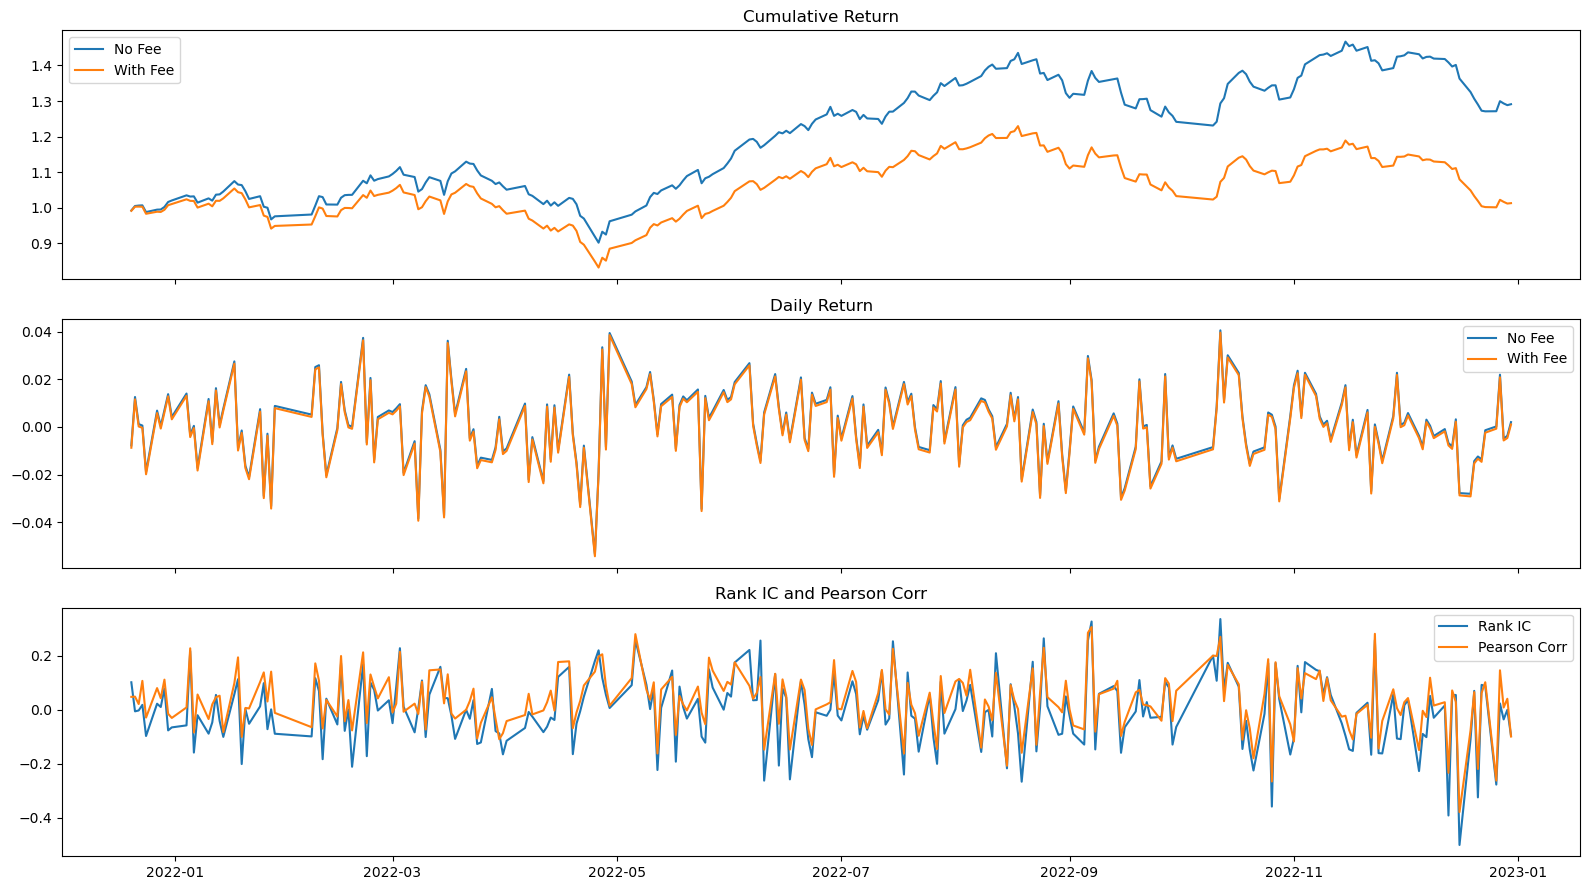

In [23]:
fig = generate_visualization(portfolio_return_nofee, portfolio_return, rank_ic,
                             pearson_corr, returns)